In [224]:
import torch
from transformers import AutoModel, AutoTokenizer
from scipy.spatial.distance import cosine
import json

with open('./data/sbom_dep2.json') as f:
   data = json.load(f)

vulnerabilities = data['vulnerabilities']

labels = []
descriptions = []
for v in vulnerabilities:
  descriptions.append(v['description'])
  
labels = descriptions
# Get our models - The package will take care of downloading the models automatically
# For best performance: Muennighoff/SGPT-5.8B-weightedmean-nli-bitfit
tokenizer = AutoTokenizer.from_pretrained("Muennighoff/SGPT-125M-weightedmean-nli-bitfit")
model = AutoModel.from_pretrained("Muennighoff/SGPT-125M-weightedmean-nli-bitfit")
# Deactivate Dropout (There is no dropout in the above models so it makes no difference here but other SGPT models may have dropout)
model.eval()

# Tokenize input texts
texts = labels
batch_tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Get the embeddings
with torch.no_grad():
    # Get hidden state of shape [bs, seq_len, hid_dim]
    last_hidden_state = model(**batch_tokens, output_hidden_states=True, return_dict=True).last_hidden_state

# Get weights of shape [bs, seq_len, hid_dim]
weights = (
    torch.arange(start=1, end=last_hidden_state.shape[1] + 1)
    .unsqueeze(0)
    .unsqueeze(-1)
    .expand(last_hidden_state.size())
    .float().to(last_hidden_state.device)
)

# Get attn mask of shape [bs, seq_len, hid_dim]
input_mask_expanded = (
    batch_tokens["attention_mask"]
    .unsqueeze(-1)
    .expand(last_hidden_state.size())
    .float()
)

# Perform weighted mean pooling across seq_len: bs, seq_len, hidden_dim -> bs, hidden_dim
sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded * weights, dim=1)
sum_mask = torch.sum(input_mask_expanded * weights, dim=1)

embeddings = sum_embeddings / sum_mask


In [138]:

df = pd.read_csv('./clusters_cleaned_SBERTV2.csv')
df.head()
labels = df["description"]
labels.tolist()

['In engineSetMode of BaseBlockCipher.java, there is a possible incorrect cryptographic algorithm chosen due to an incomplete comparison. This could lead to local information disclosure with no additional execution privileges needed. User interaction is not needed for exploitation.Product: AndroidVersions: Android-10Android ID: A-148517383',
 'A flaw was found in Keycloak before version 11.0.0, where the code base contains usages of ObjectInputStream without type checks. This flaw allows an attacker to inject arbitrarily serialized Java Objects, which would then get deserialized in a privileged context and potentially lead to remote code execution.',
 'A flaw was found in FasterXML Jackson Databind, where it did not have entity expansion secured properly. This flaw allows vulnerability to XML external entity (XXE) attacks. The highest threat from this vulnerability is data integrity.',
 'jackson-databind before 2.13.0 allows a Java StackOverflow exception and denial of service via a la

In [139]:
import pandas as pd

import torch
from transformers import AutoModel, AutoTokenizer
from scipy.spatial.distance import cosine
import json



df = pd.read_csv('./clusters_cleaned_SBERTV2.csv')
df.head()
labels = df["normalized_body"]
# Get our models - The package will take care of downloading the models automatically
# For best performance: Muennighoff/SGPT-5.8B-weightedmean-nli-bitfit
tokenizer = AutoTokenizer.from_pretrained("Muennighoff/SGPT-125M-weightedmean-nli-bitfit")
model = AutoModel.from_pretrained("Muennighoff/SGPT-125M-weightedmean-nli-bitfit")
# Deactivate Dropout (There is no dropout in the above models so it makes no difference here but other SGPT models may have dropout)
model.eval()

# Tokenize input texts
texts = labels
batch_tokens = tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors="pt")

# Get the embeddings
with torch.no_grad():
    # Get hidden state of shape [bs, seq_len, hid_dim]
    last_hidden_state = model(**batch_tokens, output_hidden_states=True, return_dict=True).last_hidden_state

# Get weights of shape [bs, seq_len, hid_dim]
weights = (
    torch.arange(start=1, end=last_hidden_state.shape[1] + 1)
    .unsqueeze(0)
    .unsqueeze(-1)
    .expand(last_hidden_state.size())
    .float().to(last_hidden_state.device)
)

# Get attn mask of shape [bs, seq_len, hid_dim]
input_mask_expanded = (
    batch_tokens["attention_mask"]
    .unsqueeze(-1)
    .expand(last_hidden_state.size())
    .float()
)

# Perform weighted mean pooling across seq_len: bs, seq_len, hidden_dim -> bs, hidden_dim
sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded * weights, dim=1)
sum_mask = torch.sum(input_mask_expanded * weights, dim=1)

embeddings = sum_embeddings / sum_mask



In [140]:
data = {'embedding': [embeddings] * len(df)}
df = pd.DataFrame(data)

In [141]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd



In [142]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('all-MiniLM-L6-v2')

# #Our sentences we like to encode
# sentences = labels

# #Sentences are encoded by calling model.encode()
# embeddings = model.encode(sentences)

# #Print the embeddings
# for sentence, embedding in zip(sentences, embeddings):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding)
#     print("")

Sentence: enginesetmode baseblockcipherjava possible incorrect cryptographic algorithm chosen due incomplete comparison could lead local information disclosure additional execution privileges needed user interaction needed exploitationproduct androidversions androidandroid id
Embedding: [-4.29068431e-02  9.08767730e-02  1.17611596e-02 -1.35086104e-01
  1.46429020e-03 -4.98586111e-02 -5.73516674e-02 -1.41987959e-02
 -3.25588435e-02 -5.69848828e-02 -5.13487961e-03 -9.23965275e-02
  9.73445997e-02 -3.29714604e-02  8.25632829e-03 -3.52214612e-02
  3.75062488e-02  2.62876078e-02  1.45337293e-02 -7.14881113e-04
  6.56245882e-03 -8.73501226e-03 -8.43585283e-03 -4.00548168e-02
  3.10424883e-02 -2.54726794e-04 -3.33274342e-02  1.67887788e-02
  5.81892990e-02 -1.03632109e-02  4.49878760e-02  7.11981580e-02
  4.03680652e-02  1.40687907e-02 -5.59140295e-02 -4.34034923e-03
 -1.71288997e-02  4.16670507e-03 -8.60834774e-03  3.19250152e-02
 -9.22979135e-03 -6.78013712e-02 -5.36811203e-02  5.54639213e-

In [225]:
print(len(embeddings[0]))

768


(454, 2)

In [123]:
# import matplotlib.pyplot as plt
# with open('./data/sbom_dep2.json') as f:
#    data = json.load(f)

# vulnerabilities = data['vulnerabilities']

In [150]:
from sklearn.cluster import DBSCAN


[{'bom-ref': '9755e92d-9302-463e-be19-fc67d4156ab8', 'id': 'CVE-2020-0187', 'source': {'name': 'NVD', 'url': 'https://nvd.nist.gov/'}, 'ratings': [{'source': {'name': 'NVD', 'url': 'https://nvd.nist.gov/'}, 'score': 2.1, 'severity': 'low', 'method': 'CVSSv2', 'vector': '(AV:L/AC:L/Au:N/C:P/I:N/A:N)'}, {'source': {'name': 'NVD', 'url': 'https://nvd.nist.gov/'}, 'score': 5.5, 'severity': 'medium', 'method': 'CVSSv3', 'vector': 'CVSS:3.0/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N'}], 'description': 'In engineSetMode of BaseBlockCipher.java, there is a possible incorrect cryptographic algorithm chosen due to an incomplete comparison. This could lead to local information disclosure with no additional execution privileges needed. User interaction is not needed for exploitation.Product: AndroidVersions: Android-10Android ID: A-148517383', 'published': '2020-06-11T15:15:00Z', 'updated': '2020-06-12T16:42:00Z', 'affects': [{'ref': '2a35813a-6a3c-423e-aa43-6195d7548c86'}]}, {'bom-ref': 'c7953449-eb28-4

[{'bom-ref': '9755e92d-9302-463e-be19-fc67d4156ab8', 'id': 'CVE-2020-0187', 'source': {'name': 'NVD', 'url': 'https://nvd.nist.gov/'}, 'ratings': [{'source': {'name': 'NVD', 'url': 'https://nvd.nist.gov/'}, 'score': 2.1, 'severity': 'low', 'method': 'CVSSv2', 'vector': '(AV:L/AC:L/Au:N/C:P/I:N/A:N)'}, {'source': {'name': 'NVD', 'url': 'https://nvd.nist.gov/'}, 'score': 5.5, 'severity': 'medium', 'method': 'CVSSv3', 'vector': 'CVSS:3.0/AV:L/AC:L/PR:L/UI:N/S:U/C:H/I:N/A:N'}], 'description': 'In engineSetMode of BaseBlockCipher.java, there is a possible incorrect cryptographic algorithm chosen due to an incomplete comparison. This could lead to local information disclosure with no additional execution privileges needed. User interaction is not needed for exploitation.Product: AndroidVersions: Android-10Android ID: A-148517383', 'published': '2020-06-11T15:15:00Z', 'updated': '2020-06-12T16:42:00Z', 'affects': [{'ref': '2a35813a-6a3c-423e-aa43-6195d7548c86'}]}, {'bom-ref': 'c7953449-eb28-4

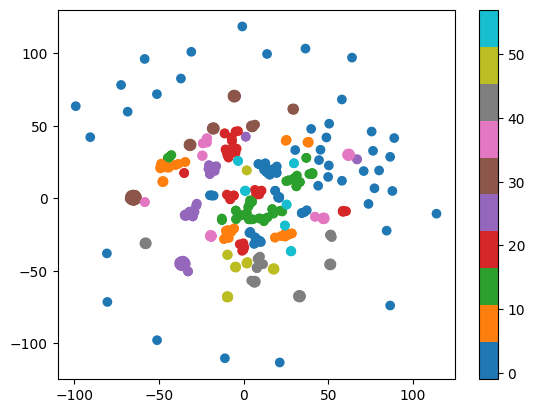

In [223]:
X = np.array(embeddings)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=5).fit_transform(X)
X_embedded.shape
scores = []
descriptions = []
print(vulnerabilities)
for v in vulnerabilities:
  if ('score' in v['ratings'][0]):
    scores.append(v['ratings'][0]['score'])
    # scores.append(v[''])
  else:
    scores.append(10)
  descriptions.append(v['description'])
# scores = pd.DataFrame(scores)
# print(cluster_data)
X = []
# for i, data in enumerate(cluster_data['x']):
#   X.append([cluster_data['x'][i], cluster_data['y'][i]])
# for i, data in enumerate(cluster_data['x']):
#   X.append([cluster_data['x'][i], cluster_data['y'][i]])
clustering = DBSCAN(eps=5, min_samples=2).fit(X_embedded)
clustering.labels_
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clustering.labels_, cmap='tab10')
plt.colorbar()


plt.show()


In [196]:
print(sorted(set(clustering.labels_)))

[0, 1]


In [192]:
cluster_data  = pd.DataFrame({'x': X_embedded[:,0], 'y': X_embedded[:,1], 'description': descriptions, 'label': clustering.labels_})


In [193]:

for label_num in sorted(set(clustering.labels_)):
  labels = []
  label_descriptions = []
  for idx, d in enumerate(cluster_data['label']):
    if d == label_num:
      labels.append(d)
      label_descriptions.append(descriptions[idx])
  df = pd.DataFrame({"label": labels, "description": label_descriptions})
  df.to_csv(f"./clusters_after_cleanV3/cluster_description_{label_num}.csv")
  print(label_num)
# for i, d in enumerate(cluster_data['label']):
#   if d == 5:
#     labels.append(d)
#     label_descriptions.append(descriptions[i])
    
# df = pd.DataFrame({"label": labels, "description": label_descriptions})
# df.to_csv("./cluster_description_5.csv")

-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [29]:
cluster_data.to_csv('./clusters_SBERT.csv')


In [194]:
cluster_data.to_json('./cluster_vis/src/clusters_SBERT.json')